<a href="https://colab.research.google.com/github/eujin99/Kaggle-PS4E8/blob/main/Test_eu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'playground-series-s4e8:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F76727%2F9045607%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240821%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240821T161806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D78d24a3d2925902e60723c9088cc4263841a0d3f7c0b590128650d5ef36b54596d83358f623c5b7ae4807ee77d1fc86bb660c2ef64509efc9e02c2ec24267e4336c3cd88e20b907596fa7533d22243d5e03af171c615dd4a68c952f89285c60625f8d43c007613a3542742e11ae7dfe74eb80f83d6b957ffe830ac7a0ee6d7e0927758d07e4aaa3bd880a7b276f7157e20dd3a923efda1f2e6c7a51029938a55bf3f87d8910f70f02aadddf28ca07849699460f6f5cb1329a77db104a184ef53c9e948792b7c4275af0072d9d36a7f3a0ba786688a4711b9baa7e6fa0b54488f70d3bf18d6d152ebaa14bd658768f58ef643cbc4128690f476bc9b99228a36be'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 86301661 bytes downloaded
Downloaded and uncompressed: playground-series-s4e8
Data source import complete.


In [2]:
# 1. 라이브러리
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
import warnings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# 2. 데이터 로드 및 기본 정보 확인
dirs = {
    "input": "/kaggle/input/playground-series-s4e8/",
    "output": "/kaggle/working/"
}

files = {
    "train": "train.csv",
    "test": "test.csv",
    "sample_submission": "sample_submission.csv",
    "submission": "submission.csv"
}

df_train = pd.read_csv(dirs["input"] + files["train"])
df_test = pd.read_csv(dirs["input"] + files["test"])

print(f"Train data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Train data shape: (3116945, 22)
Test data shape: (2077964, 21)


Missing values and their percentage:
                       Missing Values  Percentage
veil-type                    2957493   94.884350
spore-print-color            2849682   91.425482
stem-root                    2757023   88.452732
veil-color                   2740947   87.936970
stem-surface                 1980861   63.551362
gill-spacing                 1258435   40.373988
cap-surface                   671023   21.528227
gill-attachment               523936   16.809280
ring-type                     128880    4.134818
gill-color                        57    0.001829
habitat                           45    0.001444
cap-shape                         40    0.001283
stem-color                        38    0.001219
has-ring                          24    0.000770
cap-color                         12    0.000385
does-bruise-or-bleed               8    0.000257
cap-diameter                       4    0.000128


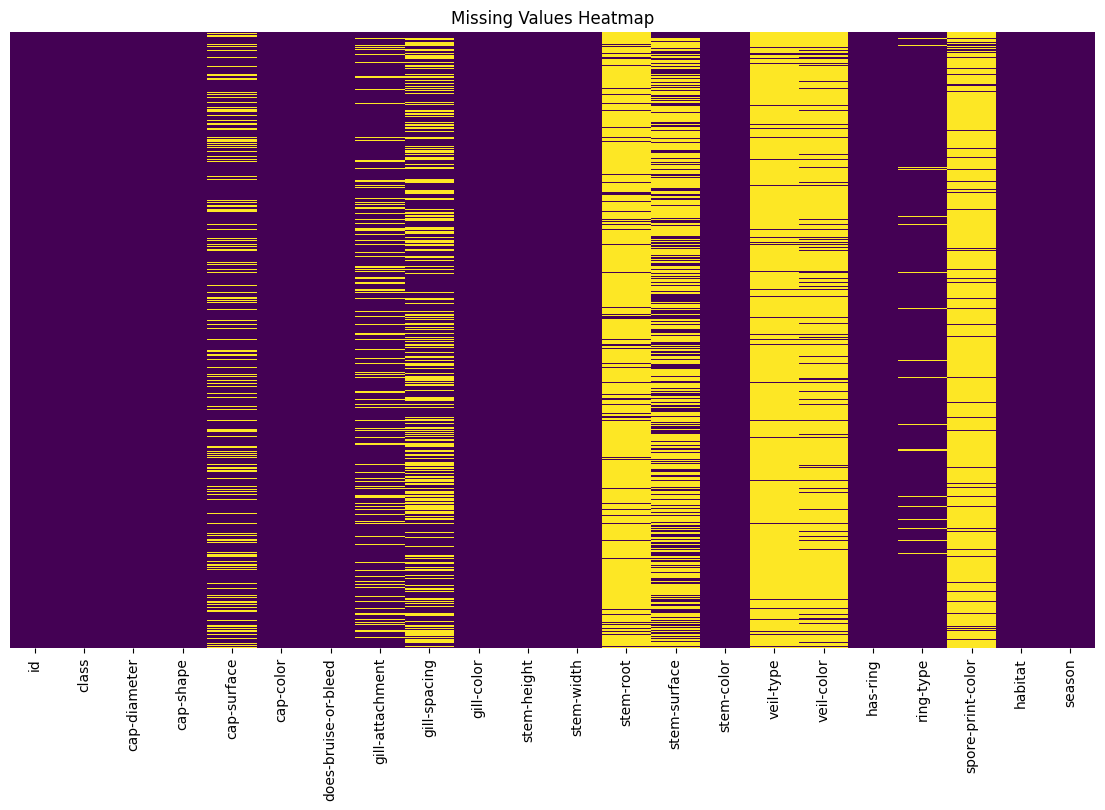

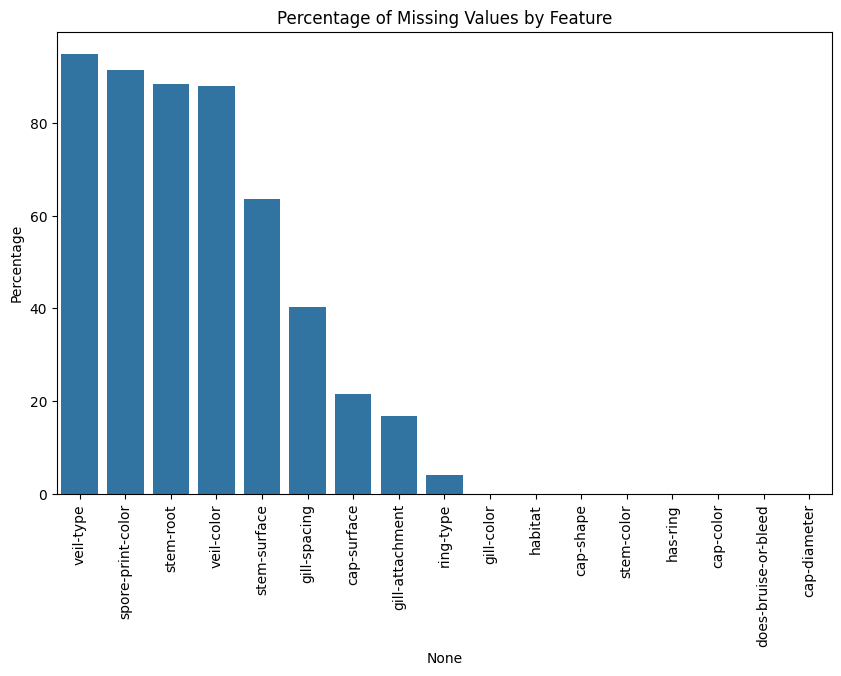

In [5]:
# 3. 결측값 분석 및 시각화
missing_data = df_train.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(df_train)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df['Missing Values'] > 0]
print("Missing values and their percentage:\n", missing_df)

plt.figure(figsize=(14, 8))
sns.heatmap(df_train.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_df.index, y=missing_df['Percentage'])
plt.xticks(rotation=90)
plt.title("Percentage of Missing Values by Feature")
plt.show()

In [6]:
# 4. 결측값 처리
def fill_missing_values(df, low_cols, medium_cols, high_cols, very_high_cols):
    for col in low_cols:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    for col in medium_cols:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    for col in high_cols:
        if df[col].dtype == "object":
            df[col].fillna("Unknown", inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)

    df.drop(columns=very_high_cols, inplace=True)

In [7]:
# 결측값 비율에 따른 컬럼 분류
# 0~5퍼
low_missing_cols = missing_df[missing_df['Percentage'] <= 5].index
# 5~20퍼
medium_missing_cols = missing_df[(missing_df['Percentage'] > 5) & (missing_df['Percentage'] <= 20)].index
# 20~50퍼
high_missing_cols = missing_df[(missing_df['Percentage'] > 20) & (missing_df['Percentage'] <= 50)].index
# 50퍼 이상
very_high_missing_cols = missing_df[missing_df['Percentage'] > 50].index

In [8]:
# 결측값 처리
fill_missing_values(df_train, low_missing_cols, medium_missing_cols, high_missing_cols, very_high_missing_cols)
print("Remaining missing values:", df_train.isnull().sum().sum())

Remaining missing values: 0


In [9]:
# 5. 데이터 인코딩
# 범주형 변수 라벨 인코딩
categorical_columns = df_train.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop('class')

# 결측값 처리
for col in categorical_columns:
    df_train[col].fillna('Unknown', inplace=True)
    if col in df_test.columns:
        df_test[col].fillna('Unknown', inplace=True)


# Train과 Test 데이터를 합쳐서 인코딩
combined_df = pd.concat([df_train[categorical_columns], df_test[categorical_columns]])


le = LabelEncoder()
for col in categorical_columns:
    combined_df[col] = le.fit_transform(combined_df[col])
    df_train[col] = combined_df[col].iloc[:df_train.shape[0]]
    df_test[col] = combined_df[col].iloc[df_train.shape[0]:]

print("범주형 변수 인코딩 완.")


범주형 변수 인코딩 완.


In [10]:
# 6. 데이터 스케일링
# 수치형 데이터 스케일링
scaler = StandardScaler()

# 수치형 컬럼 선택
numerical_columns = df_train.select_dtypes(include=['float64', 'int64']).columns
numerical_columns = [col for col in numerical_columns if col in df_test.columns]


# 실제로 수치형 데이터만 남겨두기 위해 문자열이 섞인 데이터 제거
numerical_columns_clean = []
for col in numerical_columns:
    try:
        # 문자열이 섞여 있는 경우 ValueError 발생 에러처리 해줘야할듯
        df_train[col].astype(float)
        df_test[col].astype(float)
        numerical_columns_clean.append(col)
    except ValueError:
        print(f"Warning: {col} 컬럼에 수치형이 아닌 값이 포함되어 있어서 스케일링에서 제외")

# 데이터 스케일링 적용
df_train[numerical_columns_clean] = scaler.fit_transform(df_train[numerical_columns_clean])
df_test[numerical_columns_clean] = scaler.transform(df_test[numerical_columns_clean])

print("수치형 변수 스케일링 완.")


수치형 변수 스케일링 완.


In [11]:
# 7. 데이터 분할
X = df_train.drop(columns=['class'])
y = df_train['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")

Train set size: (2493556, 16)
Validation set size: (623389, 16)


In [12]:
# 8. 데이터 불균형 처리 (SMOTE 사용)
le = LabelEncoder()
y_train = le.fit_transform(y_train)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled Train set size: {X_train_resampled.shape}")
print(f"Resampled class distribution: {np.bincount(y_train_resampled)}")


Resampled Train set size: (2728808, 16)
Resampled class distribution: [1364404 1364404]


In [13]:
# 9. 모델 학습
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

print("모델 학습 완.")


모델 학습 완.


In [14]:
# 10. 모델 평가 (필요한가,,?)
y_val_pred = xgb_model.predict(X_val)
y_val_pred = ['e' if pred == 0 else 'p' for pred in y_val_pred]

accuracy = accuracy_score(y_val, y_val_pred)
mcc = matthews_corrcoef(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation MCC: {mcc:.4f}")

Validation Accuracy: 0.9898
Validation MCC: 0.9795


In [18]:
# 11. 예측 및 결과 출력

# 1. 원본 df_test의 id 컬럼을 따로 보관
test_ids = df_test['id'].copy()

# 2. 학습에 사용된 피처들만 df_test에 남기기 (id 컬럼은 건드리지 않음)
common_columns = X_train.columns.intersection(df_test.columns)
df_test_features = df_test[common_columns]

# 3. 예측 수행
test_predictions = xgb_model.predict(df_test_features)
test_predictions = ['e' if pred == 0 else 'p' for pred in test_predictions]

# 4. 보관한 id 컬럼과 예측 결과를 함께 사용해 최종 DataFrame 생성
output = pd.DataFrame({'id': test_ids, 'class': test_predictions})

# 5. id 유지 확인 ㅜㅜ
if output['id'].equals(test_ids):
    print("id 값 유지.")
else:
    print("id 값 불일치..")

# 샘플 제출 파일 사용
sample_submission = pd.read_csv(dirs["input"] + files["sample_submission"])

# sample_submission에 test_predictions 값을 직접 할당
output = sample_submission.copy()
output['class'] = test_predictions

# 결과를 CSV 파일로 저장
output.to_csv(dirs["output"] + files["submission"], index=False)

print("csv 저장 완.")

# 저장된 CSV 파일의 상위 5개 행 출력
print("저장된 submission.csv 파일의 상위 5개 행:")
print(output.head())


id 값 유지.
csv 저장 완.
저장된 submission.csv 파일의 상위 5개 행:
        id class
0  3116945     e
1  3116946     p
2  3116947     p
3  3116948     p
4  3116949     e
